# Test Functional Coherence of GO Terms in Clusters

In [21]:
from itertools import combinations
from loguru import logger

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import jaccard
from scipy.stats import ttest_ind
from tqdm import tqdm

from philharmonic.utils import (
    add_GO_function,
    clean_top_terms,
    load_cluster_json,
    parse_GO_database,
    parse_GO_map,
)

In [57]:
# Initial Files
cluster_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_clusters.functional.json"
network_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_network.positive.tsv"
go_map_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_GO_map.csv"
cluster_func_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_cluster_graph_functions.tsv"

GO_SLIM = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/goslim_generic.obo"

from pathlib import Path
IMG_DIR = Path("/mnt/home/ssledzieski/Projects/philharmonic-experiments/img/pdam")

# # Initial Files
# cluster_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/c_goreaui/20240926_philharmonic_v0.5.0_cgoreaui/20240926_cgoreaui_clusters.json"
# network_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/c_goreaui/20240926_philharmonic_v0.5.0_cgoreaui/20240926_cgoreaui_network.positive.tsv"
# go_map_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/c_goreaui/20240926_philharmonic_v0.5.0_cgoreaui/20240926_cgoreaui_GO_map.csv"

# GO_DATABASE = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/c_goreaui/20240926_philharmonic_v0.5.0_cgoreaui/go.obo"
# GO_SLIM = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/c_goreaui/20240926_philharmonic_v0.5.0_cgoreaui/goslim_generic.obo"

# from pathlib import Path
# IMG_DIR = Path("/mnt/home/ssledzieski/Projects/philharmonic-experiments/img/cgor")

---

## Load Files

In [58]:
# Load clusters
cluster_dict = load_cluster_json(cluster_file_path)

In [59]:
# Add GO Annotations
go_map = parse_GO_map(go_map_path)
go_db = parse_GO_database(GO_SLIM)

In [60]:
for clust in cluster_dict.values():
    clust["GO_terms"] = add_GO_function(clust, go_map, go_db=go_db)
    for gt in clust["GO_terms"].keys():
        assert gt in go_db.keys()

---

## Native Cluster Coherence

In [61]:
def protein_GO_bit_vector(
    protein_id, go_map, full_go_list, id_col="seq", go_col="GO_ids"
):
    go_bv = np.zeros(len(full_go_list))
    prot_go = go_map.get(protein_id)
    if prot_go is not None:
        for gid in prot_go:
            if gid in full_go_list:
                go_bv[full_go_list.index(gid)] = 1
    return go_bv

In [62]:
go_assigned = set()
for clust in tqdm(cluster_dict.values()):
    for g in clust["GO_terms"].keys():
        go_assigned.add(g)
go_assigned = sorted(list(go_assigned))
len(go_assigned)

100%|██████████| 468/468 [00:00<00:00, 304048.06it/s]


48

In [63]:
proteins_in_clusters = []
for clust in tqdm(cluster_dict.values()):
    proteins_in_clusters.extend(clust["members"])
    proteins_in_clusters.extend(list(clust["recipe"]["degree"]["0.75"]))

100%|██████████| 468/468 [00:00<00:00, 581265.70it/s]


In [64]:
len(proteins_in_clusters)

12083

In [65]:
protein_GO_bvs = {}
for pid in proteins_in_clusters:
    protein_GO_bvs[pid] = protein_GO_bit_vector(pid, go_map, go_assigned)

cluster_jaccards = {}

for k, clust in tqdm(cluster_dict.items()):
    cjaccard = []
    for p1, p2 in combinations(clust["members"] + list(clust["recipe"]["degree"]["0.75"]), 2):
        jc = 1 - jaccard(protein_GO_bvs[p1], protein_GO_bvs[p2])
        cjaccard.append(jc)
    cluster_jaccards[k] = np.array(cjaccard)

100%|██████████| 468/468 [00:01<00:00, 388.01it/s]


---

## Shuffled Cluster Coherence

In [66]:
rng = np.random.default_rng(seed=42)
shuffled_keys = rng.permutation(list(go_map.keys()))
shuffled_go_map = {k: v for k, v in zip(shuffled_keys, go_map.values())}

In [67]:
protein_GO_bvs_perm = {}
for pid in proteins_in_clusters:
    protein_GO_bvs_perm[pid] = protein_GO_bit_vector(pid, shuffled_go_map, go_assigned)

cluster_jaccards_perm = {}

for k, clust in tqdm(cluster_dict.items()):
    cjaccard = []
    for p1, p2 in combinations(clust["members"] + list(clust["recipe"]["degree"]["0.75"]), 2):
        jc = 1 - jaccard(protein_GO_bvs_perm[p1], protein_GO_bvs_perm[p2])
        cjaccard.append(jc)
    cluster_jaccards_perm[k] = np.array(cjaccard)

100%|██████████| 468/468 [00:01<00:00, 390.22it/s]


--- 


## Compare shuffled and original coherence

In [144]:
phil_mean = [np.mean(i) for i in cluster_jaccards.values()]
permute_mean = [np.mean(i) for i in cluster_jaccards_perm.values()]
coherence_df = pd.DataFrame(
    {"cluster": list(cluster_jaccards.keys()), "PHILHARMONIC": phil_mean, "Random Clustering": permute_mean}
).melt("cluster").rename({"variable": "Clustering Method", "value": "Mean Jaccard Similarity"}, axis=1)
coherence_df.head()

,cluster,Clustering Method,Mean Jaccard Similarity
0,1820850722272676818,PHILHARMONIC,0.491071
1,1258033634750426039,PHILHARMONIC,0.528912
2,595187191250287510,PHILHARMONIC,0.299107
3,1953122705995928721,PHILHARMONIC,0.308498
4,871092547245650990,PHILHARMONIC,0.386700


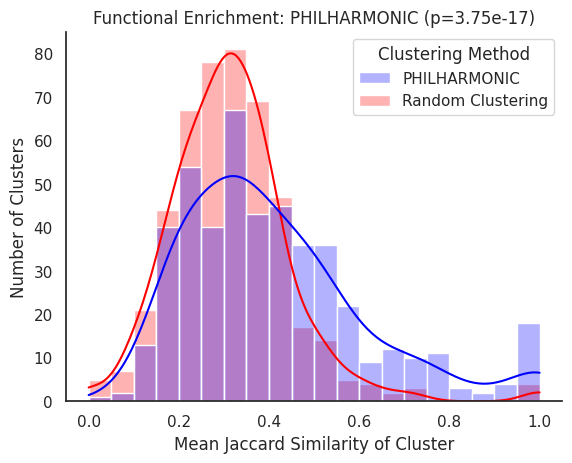

In [145]:
sns.set_palette("colorblind")
sns.set_theme(style="white", font_scale=1)
kde = True

sns.histplot(
    data=coherence_df,
    x="Mean Jaccard Similarity",
    hue="Clustering Method",
    alpha=0.3,
    bins=np.arange(0, 1.05, 0.05),
    kde=kde,
    palette=["blue", "red"],
    common_norm=False,
    ec="white",
)

# sns.histplot(
#     phil_mean,
#     color="blue",
#     label="PHILHARMONIC",
#     # bins=np.arange(0, 1.05, 0.05),
#     alpha=0.3,
#     kde=kde,
# )
# sns.histplot(
#     permute_mean,
#     color="red",
#     label="Random Baseline",
#     # bins=np.arange(0, 1.05, 0.05),
#     alpha=0.3,
#     kde=kde,
# )
tstat, p = ttest_ind(phil_mean, permute_mean, alternative="greater")

plt.title("Functional Enrichment: PHILHARMONIC (p={:.3})".format(p))
plt.xlabel("Mean Jaccard Similarity of Cluster")
plt.ylabel("Number of Clusters")
# plt.legend()
sns.despine()
# plt.savefig("../img/readme_function_enrichment.png", bbox_inches="tight", dpi=300)
# plt.savefig(IMG_DIR / "function_enrichment.svg", bbox_inches="tight", dpi=300)
plt.show()

---
## Display Coherence by GO Slim Function

In [154]:
cluster_top_terms = pd.read_csv(cluster_func_path, sep="\t").set_index("key")

In [70]:
cluster_top_terms.head()

,size,go_fn
key,,
1820850722272676818,29,inflammatory response
1258033634750426039,29,cell adhesion
595187191250287510,29,inflammatory response
1953122705995928721,29,mitotic cell cycle
871092547245650990,29,inflammatory response


In [71]:
# cluster_top_terms = {
#     k: clean_top_terms(clust, go_db, return_counts=False)
#     for k, clust in cluster_dict.items()
# }

In [109]:

clens = [len(clust["members"]) for clust in cluster_dict.values()]
clen_bin = pd.cut(clens, bins=[0, 5, 10, 15, 20, 25, 30])
cjacc = [np.mean(cluster_jaccards[k]) for k in cluster_dict]
cfunc = [cluster_top_terms.loc[int(k),"go_fn"] for k in cluster_dict]
# cfunc = [f if else "No dominant function" for f in cfunc]
func_df = pd.DataFrame(
    {"Function": cfunc, "Mean Jaccard Similarity": cjacc, "Cluster Size": clens, }
)
func_df["Function"] = func_df["Function"].str.lower()
func_df = func_df.sort_values("Function")
func_df["Function"].fillna("No dominant function", inplace=True)

# func_df = func_df[func_df["Function"] != "No dominant function"]
logger.info(func_df.shape)

2024-10-07 10:09:28.306 | INFO     | __main__:<module>:14 - (468, 3)


In [111]:
import xml.etree.ElementTree as ET

# Define the path to the XML file
xml_file_path = '../assets/philharmonic_styles.xml'

# Parse the XML file
tree = ET.parse(xml_file_path)
root = tree.getroot()

# Extract colors from the "philharmonic" style
philharmonic_colors = {}
for style in root.findall(".//discreteMappingEntry"):
    name = style.get("attributeValue").lower()
    value = style.get("value")
    philharmonic_colors[name] = value

# print(philharmonic_colors)
for f in func_df["Function"].unique():
    if f not in philharmonic_colors.keys():
        philharmonic_colors[f] = "#cccccc"

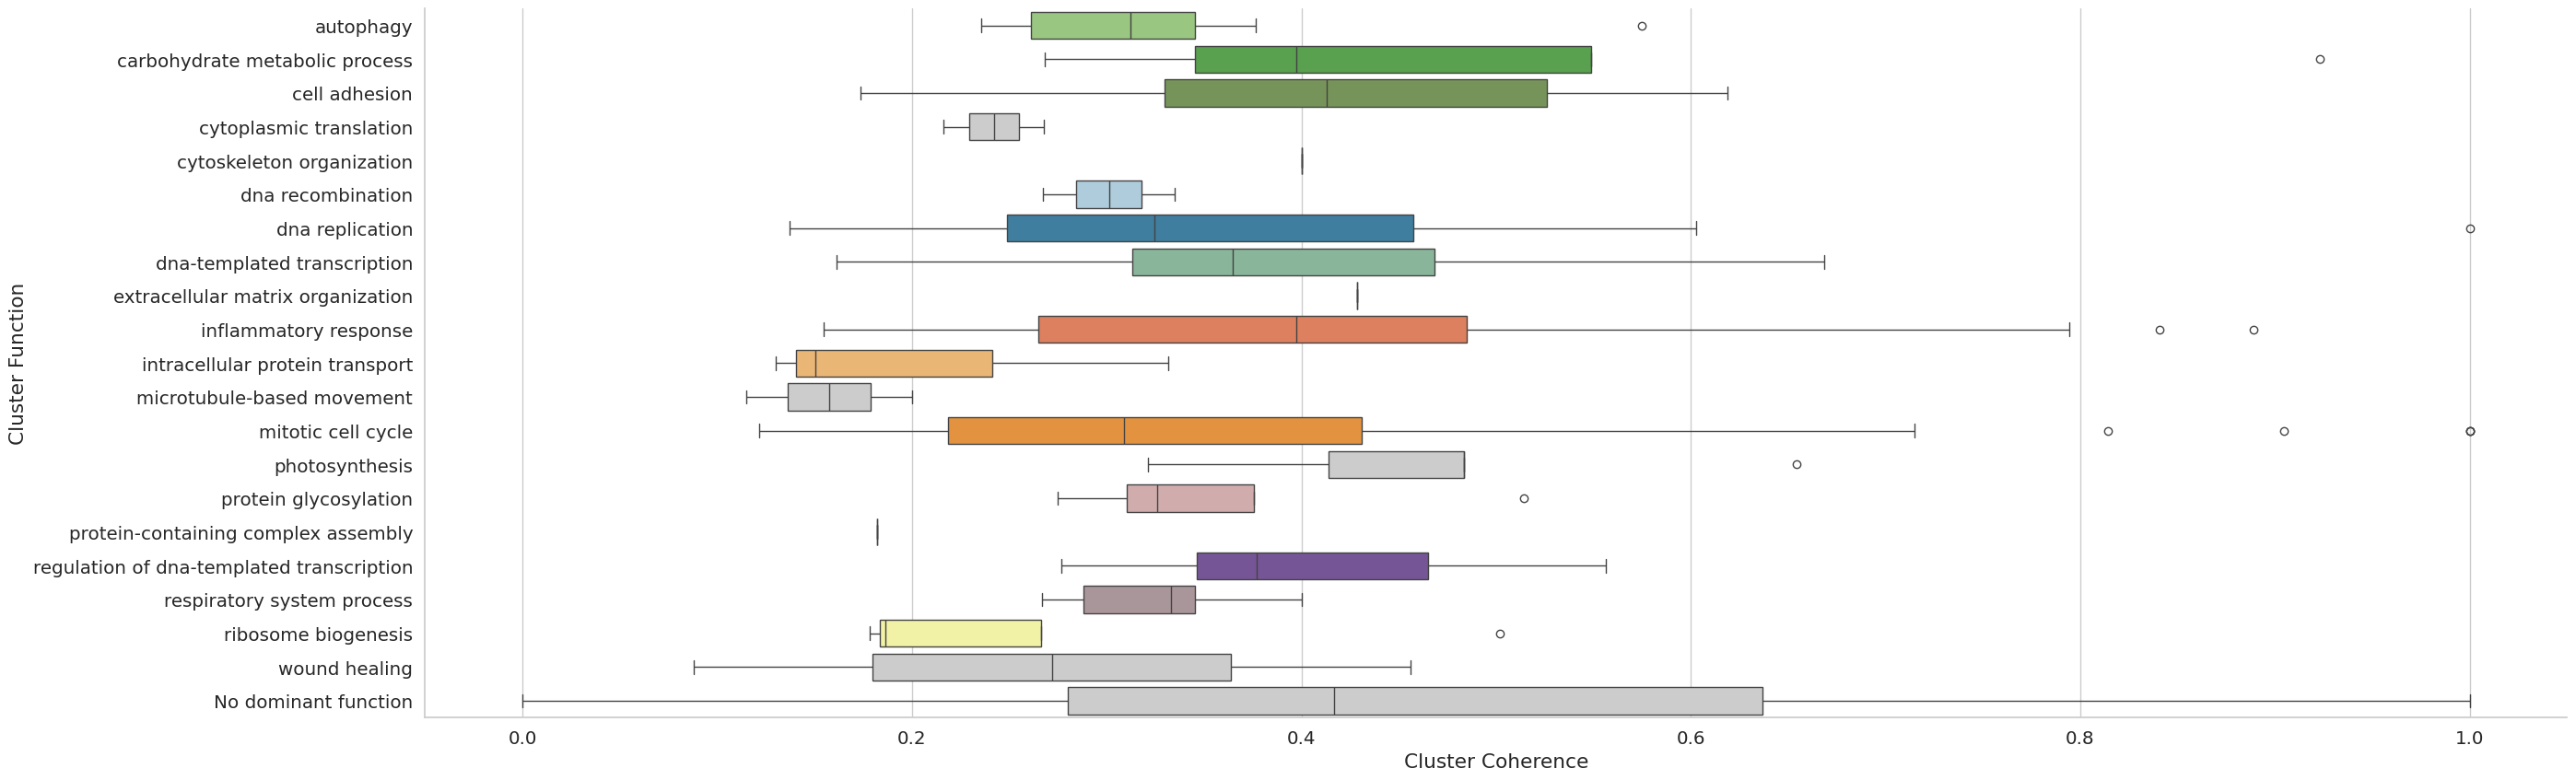

In [113]:
sns.set_theme(style="whitegrid", font_scale=1.3)
fig, ax = plt.subplots(figsize=(30, 10))

# color_map = {
#     k: v
#     for k, v in zip(sorted(set(cfunc)), sns.color_palette("Paired", len(set(cfunc))))
# }
# color_map["No function"] = (0.8, 0.8, 0.8)

# sns.scatterplot(x=clens, y=cjacc, s=80, alpha=0.8, hue=cfunc, palette=color_map, ax=ax)

# sns.swarmplot(data=func_df, x="Mean Jaccard Similarity", y="Function", ax=ax, hue="Function")#, palette=color_map)
sns.boxplot(data=func_df, x="Mean Jaccard Similarity", y="Function", ax=ax, hue="Function", palette=philharmonic_colors)
# plt.xticks(rotation=90, ha='right')
plt.xlabel("Cluster Coherence")
plt.ylabel("Cluster Function")
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine()
plt.savefig(IMG_DIR / "enrichment_by_function.svg", bbox_inches="tight", dpi=300)
plt.show()

---

## ReCIPE Validation

In [155]:
pct_func_enriched = pd.DataFrame([
    ["DREAM1","Small","Pre-ReCIPE",0.90],
    ["DREAM1","Small","Sqrt",1.0],
    ["DREAM1","Small","25%",1.0],
    ["DREAM1","Small","10%",1.0],
    ["DREAM1","Medium","10%",1.0],
    ["DREAM1","Medium","25%",0.99],
    ["DREAM1","Medium","Sqrt",0.94],
    ["DREAM1","Medium","Pre-ReCIPE",0.93],
    ["DREAM1","Large","10%",1.0],
    ["DREAM1","Large","25%",1.0],
    ["DREAM1","Large","Sqrt",1.0],
    ["DREAM1","Large","Pre-ReCIPE",0.94],
    ["DREAM2","Small","Pre-ReCIPE",1.0],
    ["DREAM2","Small","Sqrt",1.0],
    ["DREAM2","Small","25%",1.0],
    ["DREAM2","Small","10%",1.0],
    ["DREAM2","Medium","10%",1.0],
    ["DREAM2","Medium","25%",0.88],
    ["DREAM2","Medium","Sqrt",0.85],
    ["DREAM2","Medium","Pre-ReCIPE",0.84],
    ["DREAM2","Large","10%",1.0],
    ["DREAM2","Large","25%",1.0],
    ["DREAM2","Large","Sqrt",1.0],
    ["DREAM2","Large","Pre-ReCIPE",0.98],
    ["DREAM3","Small","Pre-ReCIPE",0.91],
    ["DREAM3","Small","Sqrt",0.93],
    ["DREAM3","Small","25%",1.0],
    ["DREAM3","Small","10%",1.0],
    ["DREAM3","Medium","10%",0.95],
    ["DREAM3","Medium","25%",0.99],
    ["DREAM3","Medium","Sqrt",0.94],
    ["DREAM3","Medium","Pre-ReCIPE",0.95],
    ["DREAM3","Large","10%",0.96],
    ["DREAM3","Large","25%",0.96],
    ["DREAM3","Large","Sqrt",1.0],
    ["DREAM3","Large","Pre-ReCIPE",0.96]
],columns=["Network","Cluster Size","Linear Ratio","Enrichment"])

majority_vote_f1 = pd.DataFrame([
    ["DREAM1","Small","Pre-ReCIPE",0.38],
    ["DREAM1","Small","Sqrt",0.45],
    ["DREAM1","Small","25%",0.50],
    ["DREAM1","Small","10%",0.51],
    ["DREAM1","Medium","Pre-ReCIPE",0.48],
    ["DREAM1","Medium","Sqrt",0.51],
    ["DREAM1","Medium","25%",0.51],
    ["DREAM1","Medium","10%",0.53],
    ["DREAM1","Large","Pre-ReCIPE",0.49],
    ["DREAM1","Large","Sqrt",0.51],
    ["DREAM1","Large","25%",0.49],
    ["DREAM1","Large","10%",0.51],
    ["DREAM2","Small","Pre-ReCIPE",0.37],
    ["DREAM2","Small","Sqrt",0.41],
    ["DREAM2","Small","25%",0.51],
    ["DREAM2","Small","10%",0.58],
    ["DREAM2","Medium","10%",0.58],
    ["DREAM2","Medium","25%",0.43],
    ["DREAM2","Medium","Sqrt",0.45],
    ["DREAM2","Medium","Pre-ReCIPE",0.42],
    ["DREAM2","Large","10%",0.60],
    ["DREAM2","Large","25%",0.52],
    ["DREAM2","Large","Sqrt",0.54],
    ["DREAM2","Large","Pre-ReCIPE",0.52],
    ["DREAM3","Small","Pre-ReCIPE",0.54],
    ["DREAM3","Small","Sqrt",0.54],
    ["DREAM3","Small","25%",0.58],
    ["DREAM3","Small","10%",0.68],
    ["DREAM3","Medium","Pre-ReCIPE",0.60],
    ["DREAM3","Medium","Sqrt",0.60],
    ["DREAM3","Medium","25%",0.60],
    ["DREAM3","Medium","10%",0.60],
    ["DREAM3","Large","Pre-ReCIPE",0.64],
    ["DREAM3","Large","Sqrt",0.64],
    ["DREAM3","Large","25%",0.64],
    ["DREAM3","Large","10%",0.64],
],columns=["Network","Cluster Size","Linear Ratio","Macro F1 Score"])

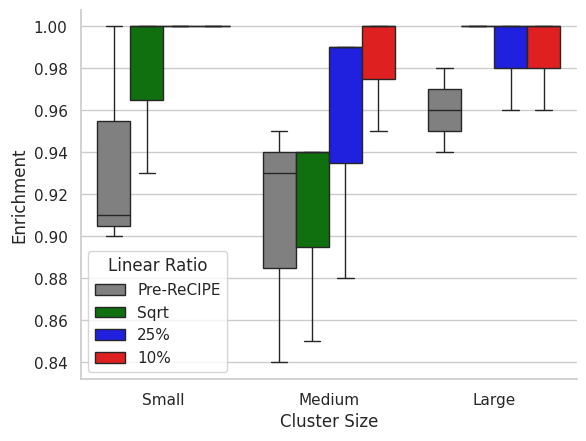

In [156]:
sns.boxplot(data=pct_func_enriched,
              x="Cluster Size", y="Enrichment",
              hue="Linear Ratio", hue_order = ["Pre-ReCIPE","Sqrt","25%","10%"],
              palette={"10%": "red", "25%": "blue", "Sqrt": "green", "Pre-ReCIPE": "grey"},
              dodge=True
            )
sns.despine()

/tmp/ipykernel_2746169/26494113.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Control","ReCIPE-Sqrt","ReCIPE-25%","ReCIPE-10%"],rotation=45, ha='right')


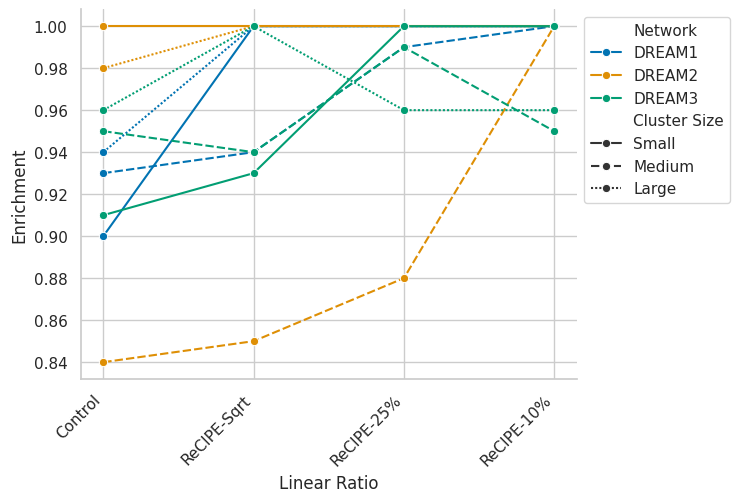

In [157]:
ax = sns.lineplot(data=pct_func_enriched,x="Linear Ratio",y="Enrichment",hue="Network",style="Cluster Size", palette="colorblind",marker="o", )
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xticklabels(["Control","ReCIPE-Sqrt","ReCIPE-25%","ReCIPE-10%"],rotation=45, ha='right')
sns.despine()

/tmp/ipykernel_2746169/1661139065.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Control","ReCIPE-Sqrt","ReCIPE-25%","ReCIPE-10%"],rotation=45, ha='right')


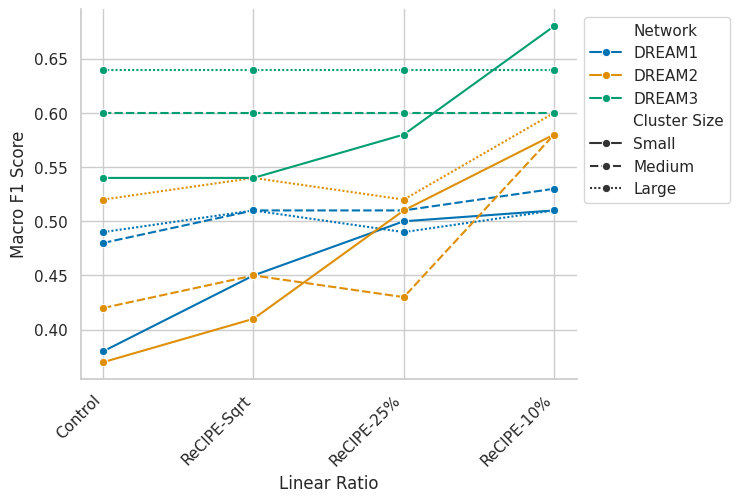

In [158]:
sns.set_style("whitegrid")
ax = sns.lineplot(data=majority_vote_f1,x="Linear Ratio",y="Macro F1 Score",hue="Network",style="Cluster Size", palette="colorblind",marker="o", )
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xticklabels(["Control","ReCIPE-Sqrt","ReCIPE-25%","ReCIPE-10%"],rotation=45, ha='right')
sns.despine()

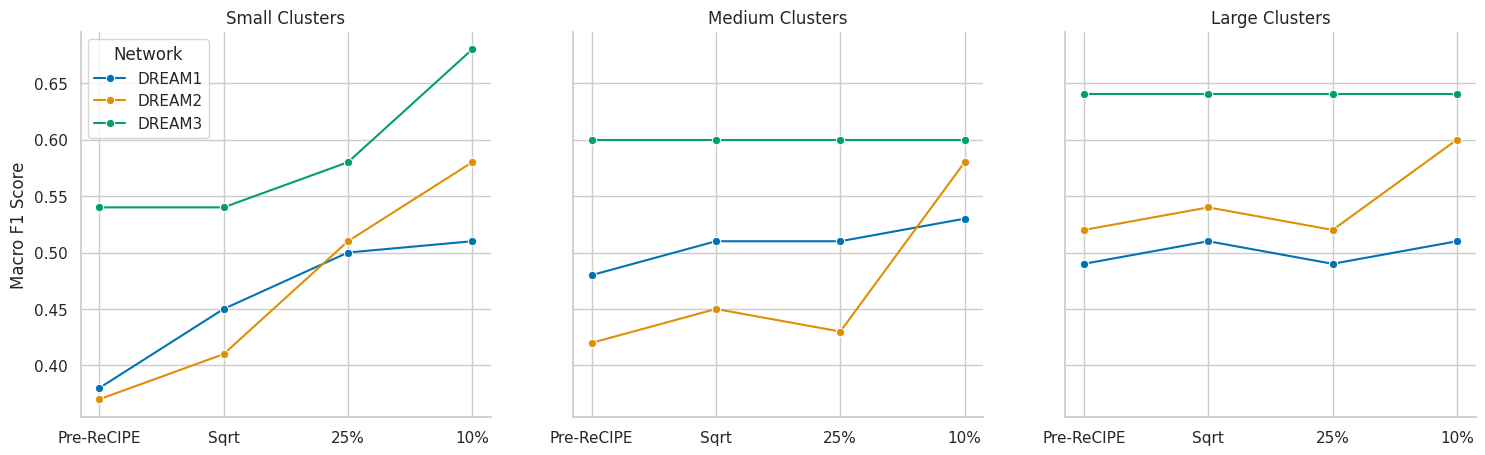

In [159]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, clsize in enumerate(["Small","Medium","Large"]):
    sns.lineplot(data=majority_vote_f1[majority_vote_f1["Cluster Size"]==clsize],x="Linear Ratio",y="Macro F1 Score",hue="Network", palette="colorblind",marker="o",ax=ax[i],legend=(i==0))
    # ax[i].set_xticklabels(["Control","ReCIPE-Sqrt","ReCIPE-25%","ReCIPE-10%"],rotation=45, ha='right')
    ax[i].set_xlabel("")
    ax[i].set_title(f"{clsize} Clusters")
sns.despine()
plt.savefig(IMG_DIR / "recipe_majority_vote_f1.svg", bbox_inches="tight", dpi=300)

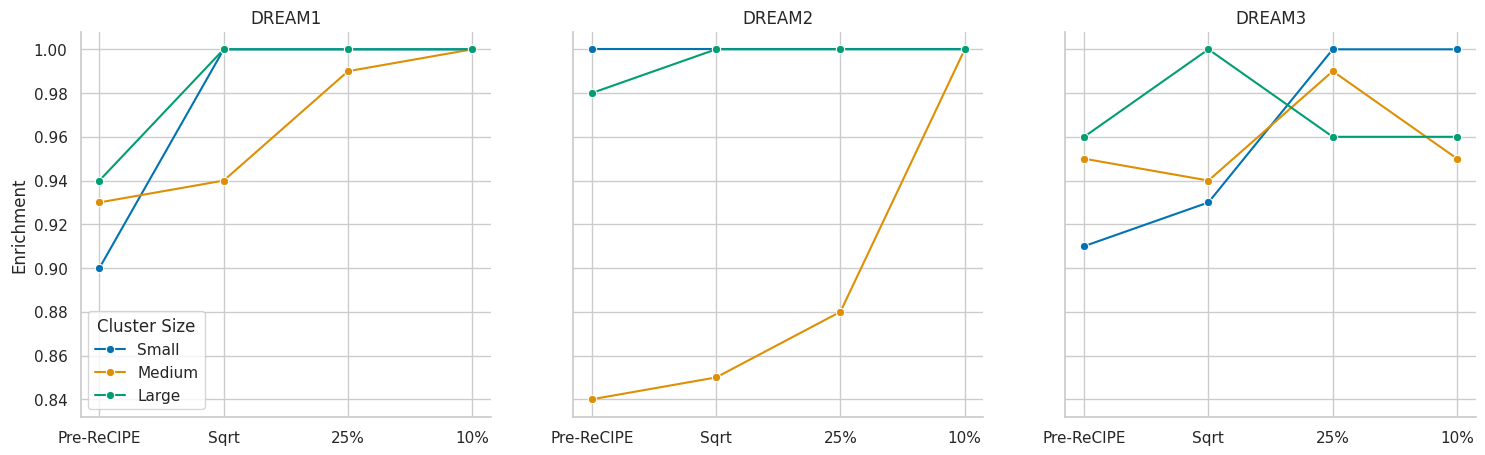

In [161]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, network in enumerate(["DREAM1","DREAM2","DREAM3"]):
    sns.lineplot(data=pct_func_enriched[pct_func_enriched["Network"]==network],x="Linear Ratio",y="Enrichment",hue="Cluster Size", palette="colorblind",marker="o",ax=ax[i],legend=(i==0))
    # ax[i].set_xticklabels(["Control","ReCIPE-Sqrt","ReCIPE-25%","ReCIPE-10%"],rotation=45, ha='right')
    ax[i].set_xlabel("")
    ax[i].set_title(f"{network}")
sns.despine()
plt.savefig(IMG_DIR / "recipe_pct_enrichment.png", bbox_inches="tight", dpi=300)
plt.show()

/tmp/ipykernel_2608577/1168735590.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(["Control","ReCIPE-Sqrt","ReCIPE-25%","ReCIPE-10%"],rotation=45, ha='right')
/tmp/ipykernel_2608577/1168735590.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(["Control","ReCIPE-Sqrt","ReCIPE-25%","ReCIPE-10%"],rotation=45, ha='right')
/tmp/ipykernel_2608577/1168735590.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(["Control","ReCIPE-Sqrt","ReCIPE-25%","ReCIPE-10%"],rotation=45, ha='right')


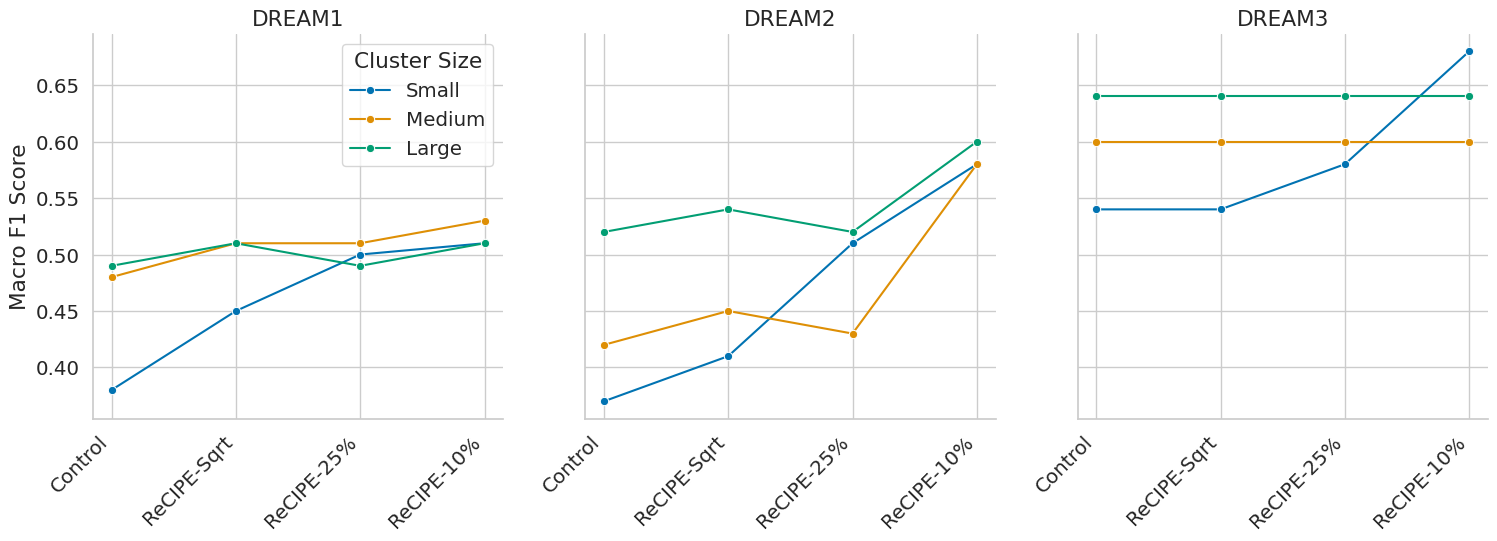

In [93]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, network in enumerate(["DREAM1","DREAM2","DREAM3"]):
    sns.lineplot(data=majority_vote_f1[majority_vote_f1["Network"]==network],x="Linear Ratio",y="Macro F1 Score",hue="Cluster Size", palette="colorblind",marker="o",ax=ax[i],legend=(i==0))
    ax[i].set_xticklabels(["Control","ReCIPE-Sqrt","ReCIPE-25%","ReCIPE-10%"],rotation=45, ha='right')
    ax[i].set_xlabel("")
    ax[i].set_title(f"{network}")
sns.despine()
plt.savefig(IMG_DIR / "recipe_majority_vote_f1.svg", bbox_inches="tight", dpi=300)
plt.show()

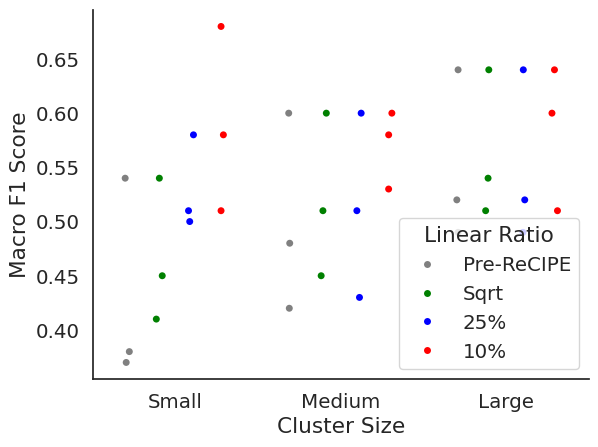

In [23]:
sns.stripplot(data=majority_vote_f1,x="Cluster Size",y="Macro F1 Score",hue="Linear Ratio",
            hue_order = ["Pre-ReCIPE","Sqrt","25%","10%"],
            palette={"10%": "red", "25%": "blue", "Sqrt": "green", "Pre-ReCIPE": "grey"},
            dodge=True
            )
sns.despine()

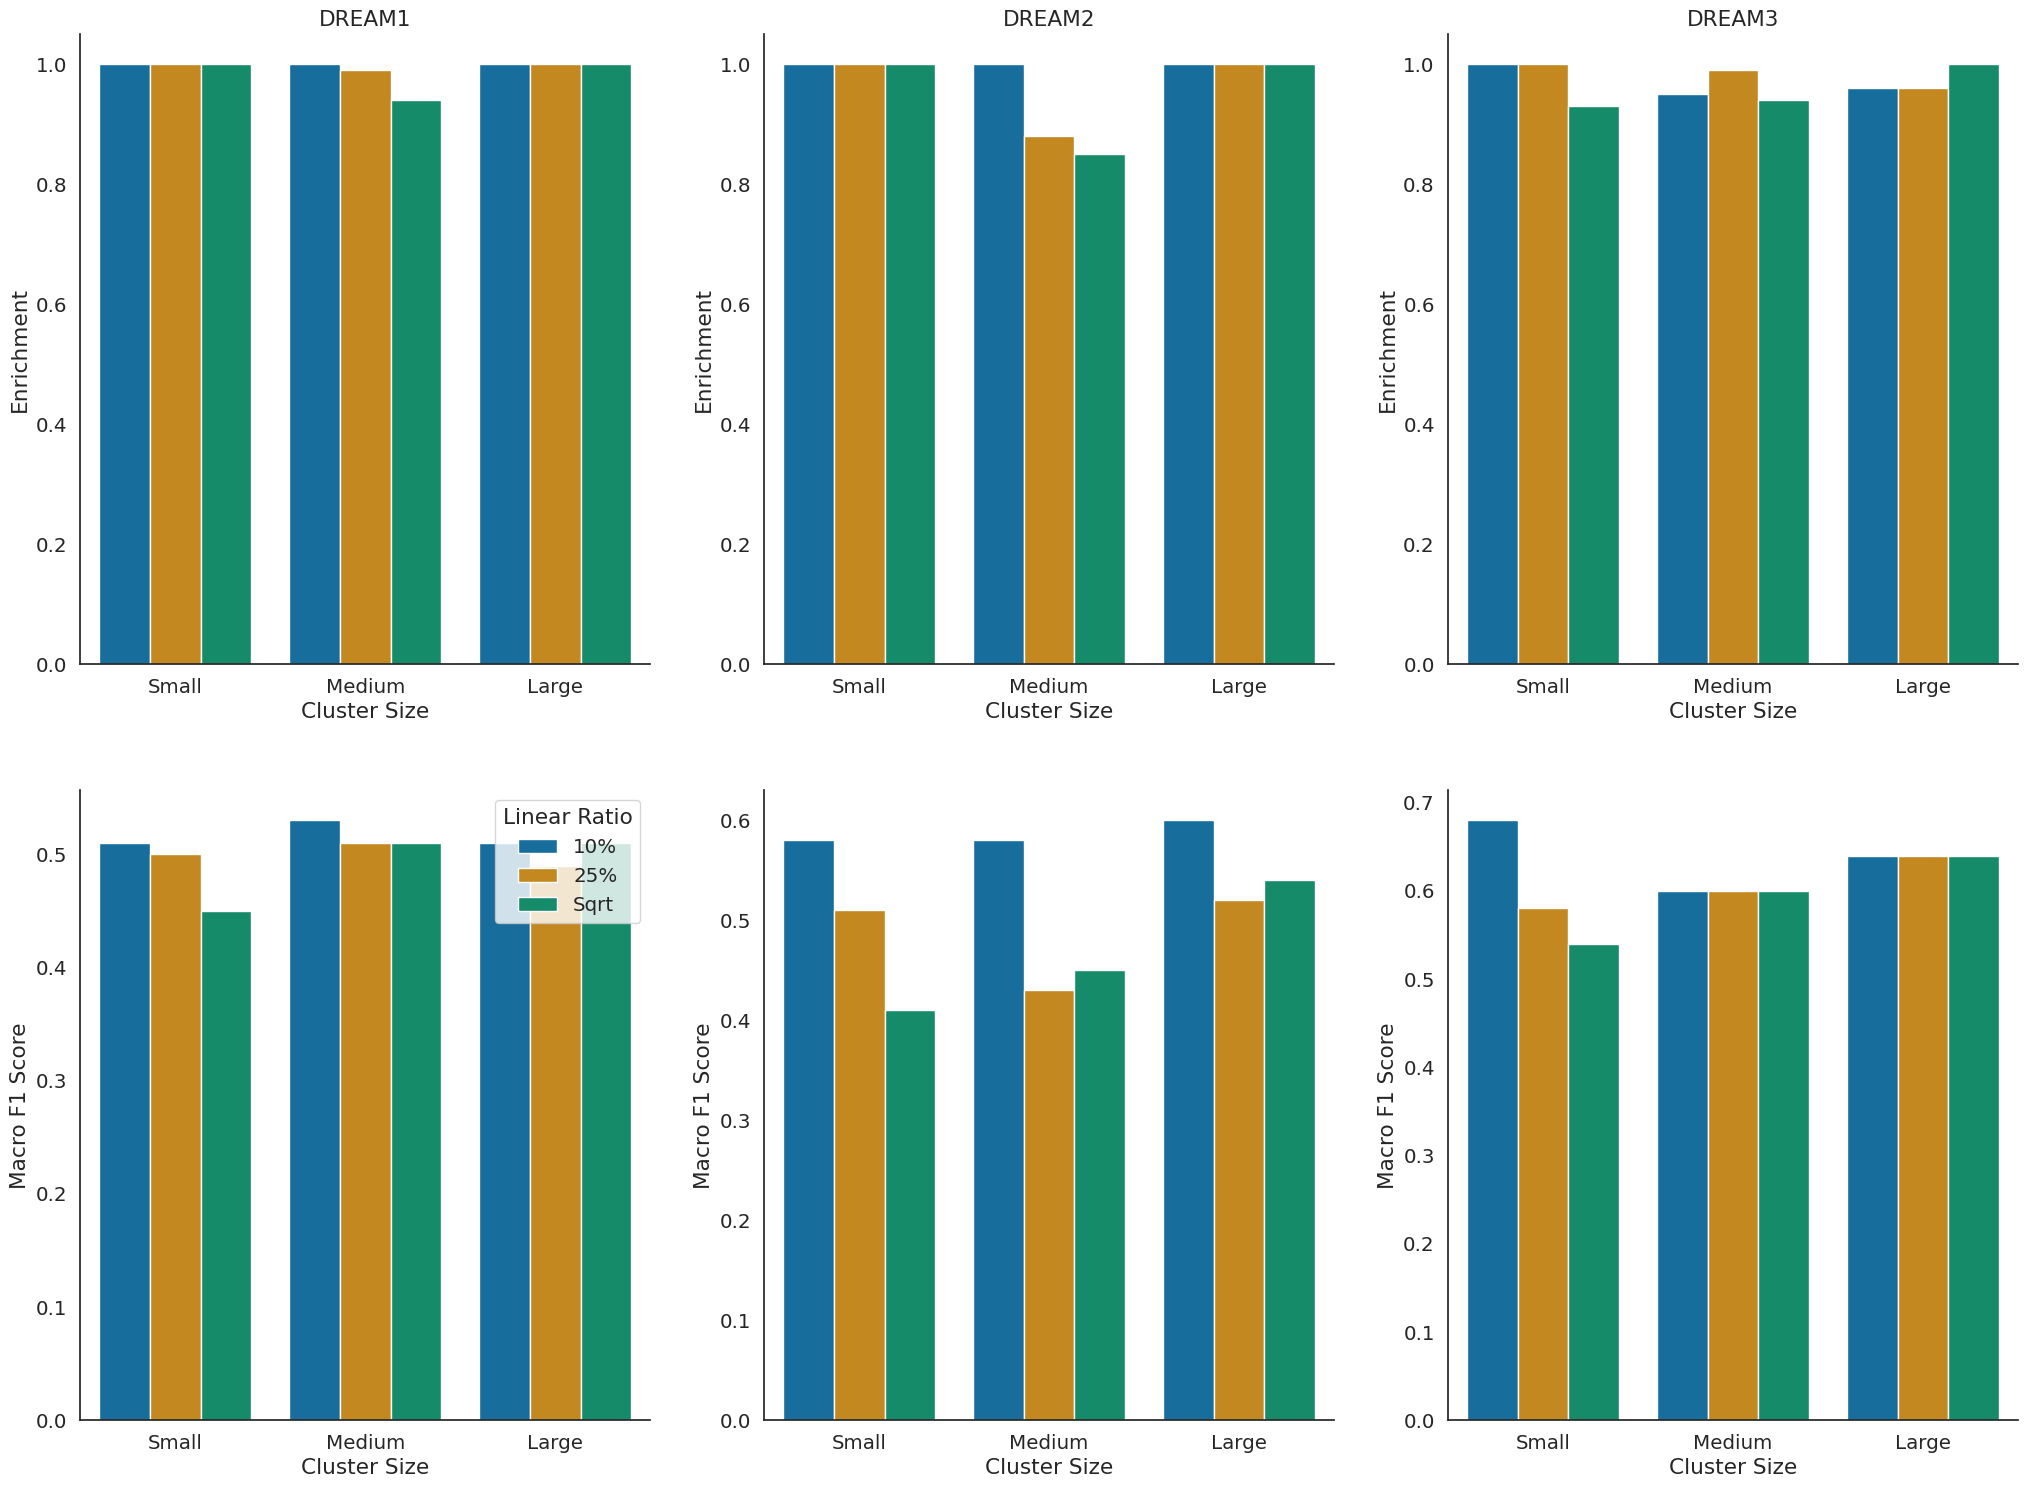

In [145]:
fig, ax = plt.subplots(2,3,figsize=(25, 18))
for i, network in enumerate(["DREAM1","DREAM2","DREAM3"]):
    legend = (network=="DREAM1")
    sns.barplot(data=pct_func_enriched[pct_func_enriched["Network"] == network],x="Cluster Size",y="Enrichment",hue="Linear Ratio", palette="colorblind", ax=ax[0][i], legend=None)
    sns.barplot(data=majority_vote_f1[majority_vote_f1["Network"] == network],x="Cluster Size",y="Macro F1 Score",hue="Linear Ratio", palette="colorblind", ax=ax[1][i], legend=legend)
    ax[0][i].set_title(network)
sns.despine()